In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import gamma

In [2]:

class CSO:

    def __init__(self, fitness, P=150, n=2, pa=0.25, beta=1.5, bound=None, 
                plot=False, min=True, verbose=False, Tmax=300):

        '''
        PARAMETERS:
        
        fitness: A FUNCTION WHICH EVALUATES COST (OR THE FITNESS) VALUE
        P: POPULATION SIZE
        n: TOTAL DIMENSIONS
        pa: ASSIGNED PROBABILITY
        beta: LEVY PARAMETER
        bound: AXIS BOUND FOR EACH DIMENSION
        X: PARTICLE POSITION OF SHAPE (P,n)
        ################ EXAMPLE #####################
        
        If ith egg Xi = [x,y,z], n = 3, and if
        bound = [(-5,5),(-1,1),(0,5)]
        Then, x∈(-5,5); y∈(-1,1); z∈(0,5)
        ##############################################
        Tmax: MAXIMUM ITERATION
        best: GLOBAL BEST POSITION OF SHAPE (n,1)
        
        '''
        self.fitness = fitness
        self.P = P 
        self.n = n
        self.Tmax = Tmax
        self.pa = pa
        self.beta = beta
        self.bound = bound
        self.plot = plot
        self.min = min
        self.verbose = verbose

        # X = (U-L)*rand + L (U AND L ARE UPPER AND LOWER BOUND OF X)
        # U AND L VARY BASED ON THE DIFFERENT DIMENSION OF X

        self.X = []

        if bound is not None:
            for (U, L) in bound:
                x = (U-L)*np.random.rand(P,) + L 
                self.X.append(x)
            self.X = np.array(self.X).T
        else:
            self.X = np.random.randn(P,n)

    def update_position_1(self):
        
        '''
        
        ACTION:
        TO CALCULATE THE CHANGE OF POSITION 'X = X + rand*C' USING LEVY FLIGHT METHOD
        C = 0.01*S*(X-best) WHERE S IS THE RANDOM STEP, and β = beta (TAKEN FROM [1])
              u
        S = -----
                1/β
             |v|
        beta = 1.5
        u ~ N(0,σu) # NORMAL DISTRIBUTION WITH ZERO MEAN AND 'σu' STANDARD DEVIATION
        v ~ N(0,σv) # NORMAL DISTRIBUTION WITH ZERO MEAN AND 'σv' STANDARD DEVIATION
        σv = 1
        
                     Γ(1+β)*sin(πβ/2)       
        σu^β = --------------------------
                   Γ((1+β)/2)*β*(2^((β-1)/2))
        Γ IS THE GAMMA FUNCTION
        '''

        num = gamma(1+self.beta)*np.sin(np.pi*self.beta/2)
        den = gamma((1+self.beta)/2)*self.beta*(2**((self.beta-1)/2))
        σu = (num/den)**(1/self.beta)
        σv = 1
        u = np.random.normal(0, σu, self.n)
        v = np.random.normal(0, σv, self.n)
        S = u/(np.abs(v)**(1/self.beta))

        # DEFINING GLOBAL BEST SOLUTION BASED ON FITNESS VALUE

        for i in range(self.P):
            if i==0:
                self.best = self.X[i,:].copy()
            else:
                self.best = self.optimum(self.best, self.X[i,:])

        Xnew = self.X.copy()
        for i in range(self.P):
            Xnew[i,:] += np.random.randn(self.n)*0.01*S*(Xnew[i,:]-self.best) 
            self.X[i,:] = self.optimum(Xnew[i,:], self.X[i,:])

    def update_position_2(self):
        
        '''
        
        ACTION:
        TO REPLACE SOME NEST WITH NEW SOLUTIONS
        HOST BIRD CAN THROW EGG AWAY (ABANDON THE NEST) WITH FRACTION
        
        pa ∈ [0,1] (ALSO CALLED ASSIGNED PROBABILITY) AND BUILD A COMPLETELY 
        
        NEW NEST. FIRST WE CHOOSE A RANDOM NUMBER r ∈ [0,1] AND IF r < pa,
        THEN 'X' IS SELECTED AND MODIFIED ELSE IT IS KEPT AS IT IS. 
        '''

        Xnew = self.X.copy()
        Xold = self.X.copy()
        for i in range(self.P):
            d1,d2 = np.random.randint(0,5,2)
            for j in range(self.n):
                r = np.random.rand()
                if r < self.pa:
                    Xnew[i,j] += np.random.rand()*(Xold[d1,j]-Xold[d2,j]) 
            self.X[i,:] = self.optimum(Xnew[i,:], self.X[i,:])
    
    def optimum(self, best, particle_x):

        '''
        PARAMETERS:
        best: GLOBAL BEST SOLUTION 'best'
        particle_x: PARTICLE POSITION
        ACTION:
        COMPARE PARTICLE'S CURRENT POSITION WITH GLOBAL BEST POSITION
        
            1. IF PROBLEM IS MINIMIZATION (min=TRUE), THEN CHECKS WHETHER FITNESS VALUE OF 'best'
            IS LESS THAN THE FITNESS VALUE OF 'particle_x' AND IF IT IS GREATER, THEN IT
            SUBSTITUTES THE CURRENT PARTICLE POSITION AS THE BEST (GLOBAL) SOLUTION
            
            2. IF PROBLEM IS MAXIMIZATION (min=FALSE), THEN CHECKS WHETHER FITNESS VALUE OF 'best'
            IS GREATER THAN THE FITNESS VALUE OF 'particle_x' AND IF IT IS LESS, THEN IT
            SUBSTITUTES THE CURRENT PARTICLE POSITION AS THE BEST (GLOBAL) SOLUTION
        
        '''
        if self.min:
            if self.fitness(best) > self.fitness(particle_x):
                best = particle_x.copy()
        else:
            if self.fitness(best) < self.fitness(particle_x):
                best = particle_x.copy()
        return best

    def clip_X(self):

        # IF BOUND IS SPECIFIED THEN CLIP 'X' VALUES SO THAT THEY ARE IN THE SPECIFIED RANGE
        
        if self.bound is not None:
            for i in range(self.n):
                xmin, xmax = self.bound[i]
                self.X[:,i] = np.clip(self.X[:,i], xmin, xmax)

    def execute(self):

        '''
        
        PARAMETERS:
        t: ITERATION NUMBER
        
        fitness_time: LIST STORING FITNESS (OR COST) VALUE FOR EACH ITERATION
        
        time: LIST STORING ITERATION NUMBER ([0,1,2,...])
        
        ACTION:
        
        AS THE NAME SUGGESTS, THIS FUNCTION EXECUTES CUCKOO SEARCH ALGORITHM
        
        BASED ON THE TYPE OF PROBLEM (MAXIMIZATION OR MINIMIZATION).
        NOTE: THIS FUNCTION PRINTS THE GLOBAL FITNESS VALUE FOR EACH ITERATION
        
        IF THE VERBOSE IS TRUE
        
        '''

        self.fitness_time, self.time = [], []

        for t in range(self.Tmax):
            self.update_position_1()
            self.clip_X()
            self.update_position_2()
            self.clip_X()
            self.fitness_time.append(self.fitness(self.best))
            self.time.append(t)
            if self.verbose:
                print('Iteration:  ',t,'| best global fitness (cost):',round(self.fitness(self.best),7))

        print('\nOPTIMUM SOLUTION\n  >', np.round(self.best.reshape(-1),7).tolist())
        print('\nOPTIMUM FITNESS\n  >', np.round(self.fitness(self.best),7))
        print()
        if self.plot:
            self.Fplot()
        
    def Fplot(self):

        # PLOTS GLOBAL FITNESS (OR COST) VALUE VS ITERATION GRAPH
        
        plt.plot(self.time, self.fitness_time)
        plt.title('Fitness value vs Iteration')
        plt.xlabel('Iteration')
        plt.ylabel('Fitness value')
        plt.show()

In [3]:
import numpy as np



def fitness_1(X):

    '''
    X: POSITION (EITHER CURRENT, LOCAL BEST OR GLOBAL BEST) OF SIZE (n,)
    2-DIMENSIONAL VECTORS (X = (x,y))
    #################################################################################
    HIMMELBLAU'S FUNCTION
    MINIMIZE f(x) = (x^2 + y - 11)^2 + (x + y^2 - 7)^2
    
    OPTIMUM SOLUTION IS x* = 3 AND y* = 2
    REPLACE 'f' BELOW WITH THIS TO TEST EXAMPLE-1
    f = (x**2 + y - 11)**2 + (x + y**2 - 7)**2
    '''
    X = np.array(X).reshape(-1,1)
    x, y = X[0][0], X[1][0]
    f = (x**2 + y - 11)**2 + (x + y**2 - 7)**2
    return f

######################## FITNESS FUNCTION 2 ######################################

def fitness_2(X):

    '''
    X: POSITION (EITHER CURRENT, LOCAL BEST OR GLOBAL BEST) OF SIZE (n,)
    2-DIMENSIONAL VECTORS (X = (x,y))
    #################################################################################
    BOOTH'S FUNCTION
    MINIMIZE f(x) = (x + 2y - 7)^2 + (2x + y - 5)^2
    OPTIMUM SOLUTION IS x* = 1 AND y* = 3
    REPLACE 'f' BELOW WITH THIS TO TEST EXAMPLE-2
    f = (x + 2*y - 7)**2 + (2*x + y - 5)**2
    '''
    X = np.array(X).reshape(-1,1)
    x, y = X[0][0], X[1][0]
    f = (x + 2*y - 7)**2 + (2*x + y - 5)**2
    return f

######################## FITNESS FUNCTION 3 ######################################

def fitness_3(X):

    '''
    X: POSITION (EITHER CURRENT, LOCAL BEST OR GLOBAL BEST) OF SIZE (n,)
    2-DIMENSIONAL VECTORS (X = (x,y))
    #################################################################################
    BEALE'S FUNCTION
    MINIMIZE f(x) = (1.5 - x - xy)^2 + (2.25 - x + xy^2)^2 + (2.625 - x + xy^3)^2
    OPTIMUM SOLUTION IS x* = 3 AND y* = 0.5
    REPLACE 'f' BELOW WITH THIS TO TEST EXAMPLE-3
    f = (1.5 - x + x*y)**2 + (2.25 - x + x*(y**2))**2 + (2.625 - x + x*(y**3))**2
    
    #################################################################################
    '''
    X = np.array(X).reshape(-1,1)
    x, y = X[0][0], X[1][0]
    f = (1.5 - x + x*y)**2 + (2.25 - x + x*(y**2))**2 + (2.625 - x + x*(y**3))**2
    return f

def fitness_4(X):

    '''
    X: POSITION (EITHER CURRENT, LOCAL BEST OR GLOBAL BEST) OF SIZE (n,)
    2-DIMENSIONAL VECTORS (X = (x,y))
    #################################################################################
    MAXIMIZE f(x) = 2xy + 2x - x^2 - 2y^2
    OPTIMUM SOLUTION IS x* = 2 AND y* = 1
    REPLACE 'f' BELOW WITH THIS TO TEST fitness_4
    f = 2*x*y + 2*x - x**2 - 2*(y**2)
    
    #################################################################################
    '''
    X = np.array(X).reshape(-1,1)
    x, y = X[0][0], X[1][0]
    f = 2*x*y + 2*x - x**2 - 2*(y**2)
    return f

def fitness_5(X):

    '''
    X: POSITION (EITHER CURRENT, LOCAL BEST OR GLOBAL BEST) OF SIZE (n,)
    2-DIMENSIONAL VECTORS (X = (x,y))
    #################################################################################
    BIVARIATE MICHAELWICZ FUNCTION
    MINIMIZE f(x) = -sin(x)*(sin(x^2/π)^2m) - sin(y)*(sin(2y^2/π)^2m)
    OPTIMUM SOLUTION IS x* = 2.20319, AND y* = 1.57049
    REPLACE 'f' BELOW WITH THIS TO TEST EXAMPLE-5
    f = -np.sin(x)*(np.sin(x*x/np.pi)**(2*m))-np.sin(y)*(np.sin(2*y*y/np.pi)**(2*m))
    '''
    X = np.array(X).reshape(-1,1)
    m = 10
    x, y = X[0][0], X[1][0]
    f = -np.sin(x)*(np.sin(x*x/np.pi)**(2*m))-np.sin(y)*(np.sin(2*y*y/np.pi)**(2*m))
    return f


Iteration:   0 | best global fitness (cost): 42.746869
Iteration:   1 | best global fitness (cost): 42.746869
Iteration:   2 | best global fitness (cost): 26.0978091
Iteration:   3 | best global fitness (cost): 26.0978091
Iteration:   4 | best global fitness (cost): 5.6134812
Iteration:   5 | best global fitness (cost): 5.6134812
Iteration:   6 | best global fitness (cost): 5.6134812
Iteration:   7 | best global fitness (cost): 1.2945284
Iteration:   8 | best global fitness (cost): 1.2945284
Iteration:   9 | best global fitness (cost): 1.2945284
Iteration:   10 | best global fitness (cost): 1.2945284
Iteration:   11 | best global fitness (cost): 1.2945284
Iteration:   12 | best global fitness (cost): 1.2945284
Iteration:   13 | best global fitness (cost): 1.2945284
Iteration:   14 | best global fitness (cost): 1.2945284
Iteration:   15 | best global fitness (cost): 1.2945284
Iteration:   16 | best global fitness (cost): 1.2945284
Iteration:   17 | best global fitness (cost): 1.2945284


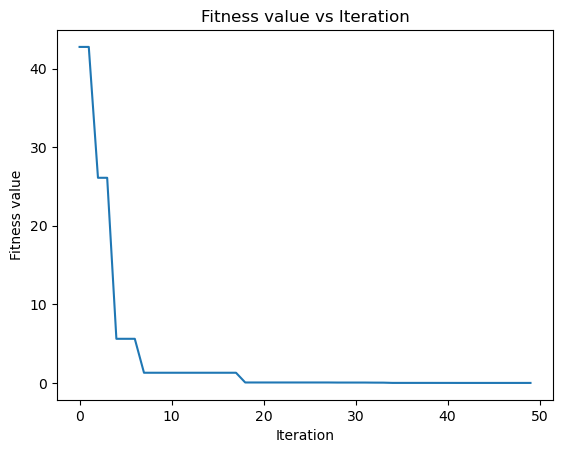

In [6]:
CSO(fitness=fitness_1, Tmax=50, verbose=True, plot = True).execute()

Iteration:   0 | best global fitness (cost): 3.1348125
Iteration:   1 | best global fitness (cost): 0.6738663
Iteration:   2 | best global fitness (cost): 0.6738663
Iteration:   3 | best global fitness (cost): 0.3805028
Iteration:   4 | best global fitness (cost): 0.315192
Iteration:   5 | best global fitness (cost): 0.0469132
Iteration:   6 | best global fitness (cost): 0.0469132
Iteration:   7 | best global fitness (cost): 0.0077688
Iteration:   8 | best global fitness (cost): 0.0077688
Iteration:   9 | best global fitness (cost): 0.0077688
Iteration:   10 | best global fitness (cost): 0.0077688
Iteration:   11 | best global fitness (cost): 0.0077688
Iteration:   12 | best global fitness (cost): 0.0077688
Iteration:   13 | best global fitness (cost): 0.0077688
Iteration:   14 | best global fitness (cost): 0.0077688
Iteration:   15 | best global fitness (cost): 0.0077688
Iteration:   16 | best global fitness (cost): 0.0077688
Iteration:   17 | best global fitness (cost): 0.0077688
Ite

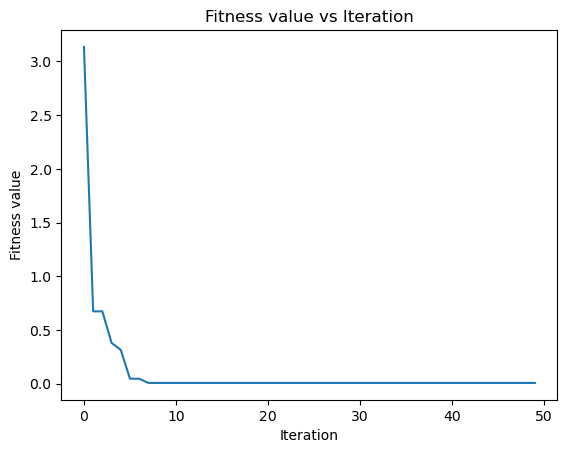

In [5]:
CSO(fitness=fitness_2, Tmax=50, verbose=True, plot = 2).execute()

Iteration:   0 | best global fitness (cost): 0.9375243
Iteration:   1 | best global fitness (cost): 0.3819176
Iteration:   2 | best global fitness (cost): 0.3819176
Iteration:   3 | best global fitness (cost): 0.3819176
Iteration:   4 | best global fitness (cost): 0.3819176
Iteration:   5 | best global fitness (cost): 0.3569439
Iteration:   6 | best global fitness (cost): 0.3569439
Iteration:   7 | best global fitness (cost): 0.3569439
Iteration:   8 | best global fitness (cost): 0.2692865
Iteration:   9 | best global fitness (cost): 0.2692865
Iteration:   10 | best global fitness (cost): 0.2625874
Iteration:   11 | best global fitness (cost): 0.2625874
Iteration:   12 | best global fitness (cost): 0.2625874
Iteration:   13 | best global fitness (cost): 0.2625874
Iteration:   14 | best global fitness (cost): 0.1243804
Iteration:   15 | best global fitness (cost): 0.1243804
Iteration:   16 | best global fitness (cost): 0.1243804
Iteration:   17 | best global fitness (cost): 0.1243804
It

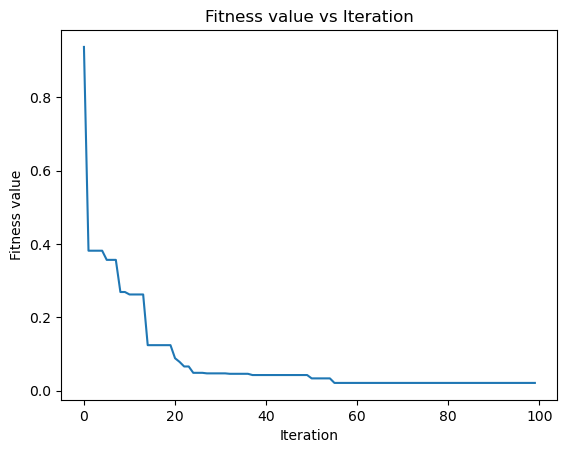

In [8]:
CSO(fitness=fitness_3, Tmax=100, verbose=True, plot = True).execute()


Iteration:   0 | best global fitness (cost): 1.6204934
Iteration:   1 | best global fitness (cost): 1.8090352
Iteration:   2 | best global fitness (cost): 1.8090352
Iteration:   3 | best global fitness (cost): 1.8090352
Iteration:   4 | best global fitness (cost): 1.9448003
Iteration:   5 | best global fitness (cost): 1.9448003
Iteration:   6 | best global fitness (cost): 1.9487097
Iteration:   7 | best global fitness (cost): 1.9487097
Iteration:   8 | best global fitness (cost): 1.9494939
Iteration:   9 | best global fitness (cost): 1.9494939
Iteration:   10 | best global fitness (cost): 1.9495092
Iteration:   11 | best global fitness (cost): 1.9782251
Iteration:   12 | best global fitness (cost): 1.9782251
Iteration:   13 | best global fitness (cost): 1.9782251
Iteration:   14 | best global fitness (cost): 1.9782251
Iteration:   15 | best global fitness (cost): 1.9782251
Iteration:   16 | best global fitness (cost): 1.9782251
Iteration:   17 | best global fitness (cost): 1.9782251
It

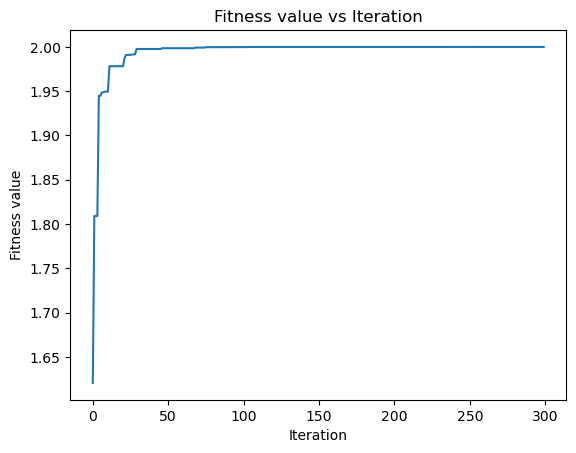

In [4]:
CSO(fitness=fitness_4, bound=[(-4,4),(-4,4)], min=False, verbose = True, plot = True).execute()

Iteration:   0 | best global fitness (cost): -1.3851871
Iteration:   1 | best global fitness (cost): -1.3851871
Iteration:   2 | best global fitness (cost): -1.3851871
Iteration:   3 | best global fitness (cost): -1.3851871
Iteration:   4 | best global fitness (cost): -1.3851871
Iteration:   5 | best global fitness (cost): -1.3851871
Iteration:   6 | best global fitness (cost): -1.3851871
Iteration:   7 | best global fitness (cost): -1.3851871
Iteration:   8 | best global fitness (cost): -1.3851871
Iteration:   9 | best global fitness (cost): -1.3851871
Iteration:   10 | best global fitness (cost): -1.3851871
Iteration:   11 | best global fitness (cost): -1.3851871
Iteration:   12 | best global fitness (cost): -1.3851871
Iteration:   13 | best global fitness (cost): -1.3851871
Iteration:   14 | best global fitness (cost): -1.3851871
Iteration:   15 | best global fitness (cost): -1.7744275
Iteration:   16 | best global fitness (cost): -1.7744275
Iteration:   17 | best global fitness (co

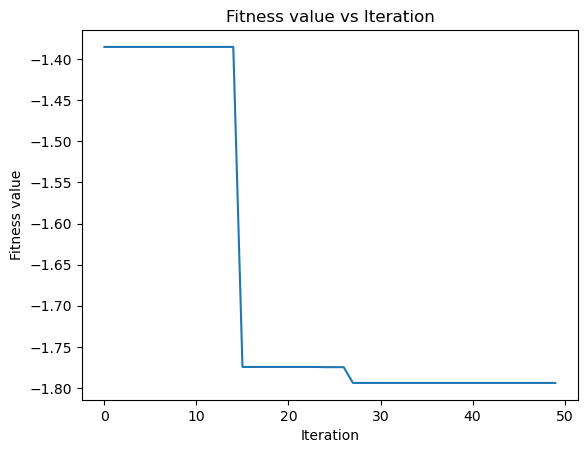

In [7]:
CSO(fitness=fitness_5, Tmax=50, verbose=True, plot = True).execute()
